# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

import os
import zipfile
import urllib.request

training_file = './data/train.p'
testing_file = './data/test.p'
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip'

if not os.path.isfile(training_file):
    data_dir = os.path.dirname(training_file)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    zip_file = os.path.join(data_dir, 'traffic-signs-data.zip')
    
    print('Downloading file...')
    urllib.request.urlretrieve(url, zip_file)
    
    print('Unzipping file...')
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(data_dir)
        
    print('Done')
        
assert(os.path.isfile(training_file))
assert(os.path.isfile(testing_file))

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
# settings
DOWNSAMPLING = 1

DATA_AUGMENTATION_MULTIPLIER = 7
COARSE_TUNING_EPOCHS = 2
COARSE_TUNING_DOWNSAMPLING = 0.02

FINE_TUNING_CANDIDATES = 3
FINE_TUNING_EPOCHS = 10
FINE_TUNING_DOWNSAMPLING = 0.1

TRAINING_EPOCHS = 20


In [3]:
# downsampling
# for local experimenting and testing before running in AWS server
import numpy as np

if DOWNSAMPLING < 0.99:
    perm = np.random.permutation(len(X_train))
    n_train = int(DOWNSAMPLING*len(X_train))
    X_train = X_train[perm[:n_train]]
    y_train = y_train[perm[:n_train]]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

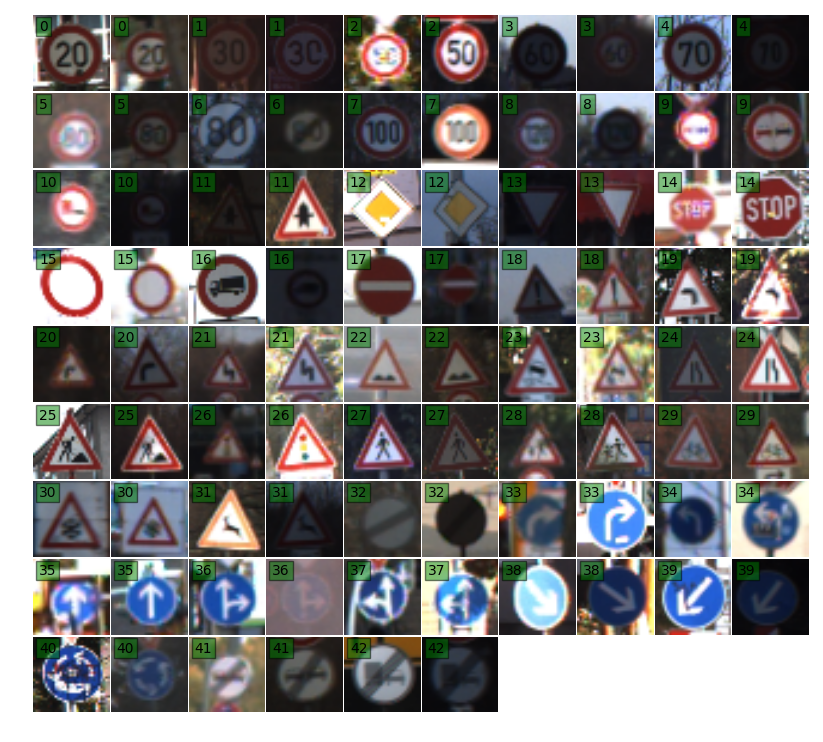

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Visualizations will be shown in the notebook.
%matplotlib inline

classes_displayed = range(43)
n_classes_per_row = 5
n_cols = 2
n_rows = (len(classes_displayed) + n_classes_per_row - 1)//n_classes_per_row

plt.figure(figsize=(n_cols*n_classes_per_row,n_rows))
gs1 = gridspec.GridSpec(n_rows,n_cols*n_classes_per_row)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
for i in range(len(classes_displayed)):
    index = np.where(y_train==classes_displayed[i])[0]
    random_selection = np.random.choice(index, n_cols, replace = False)
    sampled_images = X_train[random_selection,:,:,:]
    for j in range(n_cols):
        ax = plt.subplot(gs1[i*n_cols + j])
        plt.imshow(sampled_images[j,:,:,:])
        ax.text(2,6,str(i), bbox={'facecolor':'green', 'alpha':0.5, 'pad':2})
        plt.axis('off')



<Container object of 43 artists>

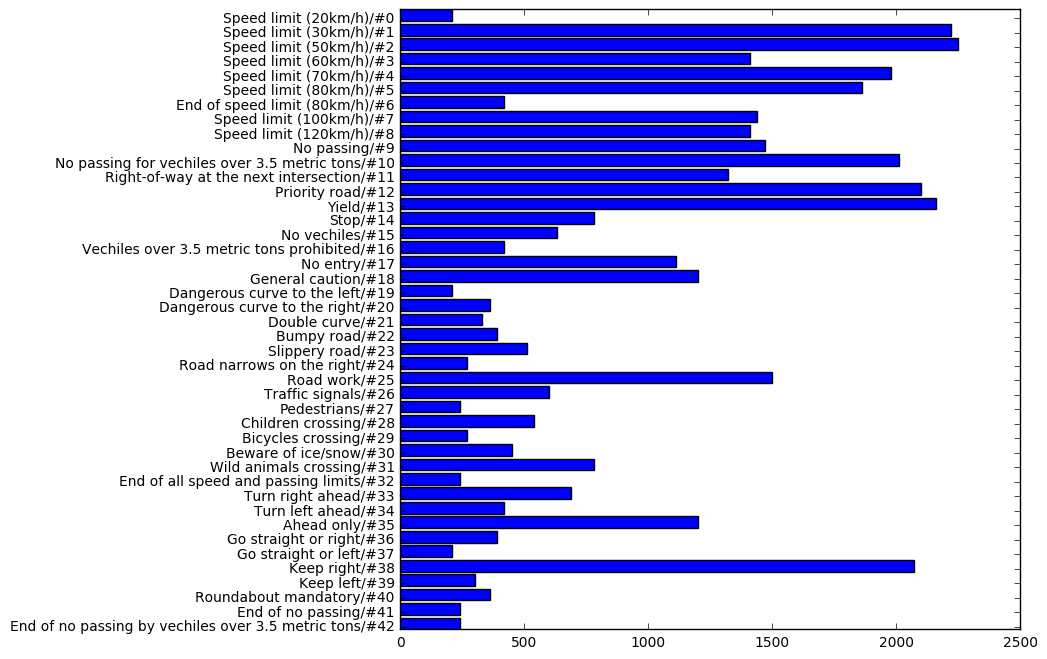

In [6]:
%matplotlib inline
with open('./signnames.csv', 'r') as inputfile:
    signnames = ['/#'.join(reversed(line.strip().split(','))) for line in inputfile]
pos = n_classes-np.arange(n_classes)
plt.figure(figsize=(8,8))
plt.yticks(pos + 0.2, signnames[1:])
plt.barh(pos, np.bincount(y_train))


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Brigtness normalization
There is a lot variation in brigtness across photos and within photos. CLAHE (Contrast Limited Adaptive Histogram Equalization) is used to normalize brightness across photos and balance constrast within photos.

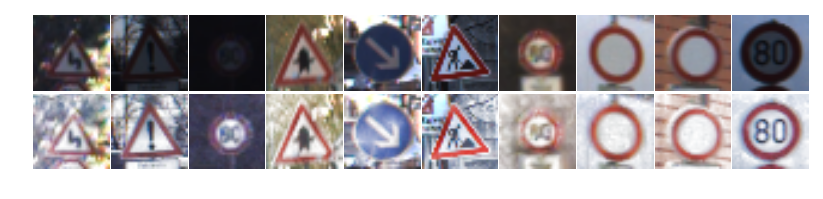

In [7]:
import cv2

clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4,4))

def brightness_normalize(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    hls[:,:,1] = clahe.apply(hls[:,:,1])
    return cv2.cvtColor(hls, cv2.COLOR_HLS2BGR)

n_cols = 10
plt.figure(figsize=(n_cols,2))
gs1 = gridspec.GridSpec(2,n_cols)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
for i in range(n_cols):
    img = X_train[np.random.choice(len(X_train))]
    ax = plt.subplot(gs1[i])
    plt.imshow(img)
    plt.axis('off')
    ax = plt.subplot(gs1[i+n_cols])
    plt.imshow(brightness_normalize(img))
    plt.axis('off')


#### Data augmentation
Generating new photos by transforming existing ones in the training set. The following transfomations are used: rotation, shear, rescale and Gaussian blur.

In [8]:
import cv2

def combine_transformation_matrix(m1, m2):
    m1 = np.vstack((m1, [0,0,1]))
    m2 = np.vstack((m2, [0,0,1]))
    return np.matmul(m1,m2)[:-1,:]

def jitter(img, angle_r, angle_x, angle_y, scale, blur):
    r,c = img.shape[:2]
    rotation = cv2.getRotationMatrix2D((c/2,r/2), angle_r, scale)
    src = np.float32([[c,0],[0,r],[0,0]])
    dst = np.float32([[c,0],[0,r],np.tan(np.deg2rad([angle_x,angle_y]))*[c,r]])
    shear = cv2.getAffineTransform(src,dst)
    new_img = cv2.warpAffine(img, combine_transformation_matrix(rotation, shear), (c,r))
    return cv2.GaussianBlur(new_img, (7,7), 0.7) if blur else new_img
    
def random_jitter(img, angles_r=(-10,0,10), angles_x=(-7,0,7), angles_y=(-7,0,7), scales = (0.9,1,1.1), blurs=(True, False)):
    angle_r = np.random.choice(angles_r)
    angle_x = np.random.choice(angles_x)
    angle_y = np.random.choice(angles_y)
    scale = np.random.choice(scales)
    blur = np.random.choice(blurs)
    return jitter(img, angle_r, angle_x, angle_y, scale, blur)

def multiple_random_jitters(img, n_sample):
    return [random_jitter(img) for _ in range(n_sample)]

#### Display newly generated photos


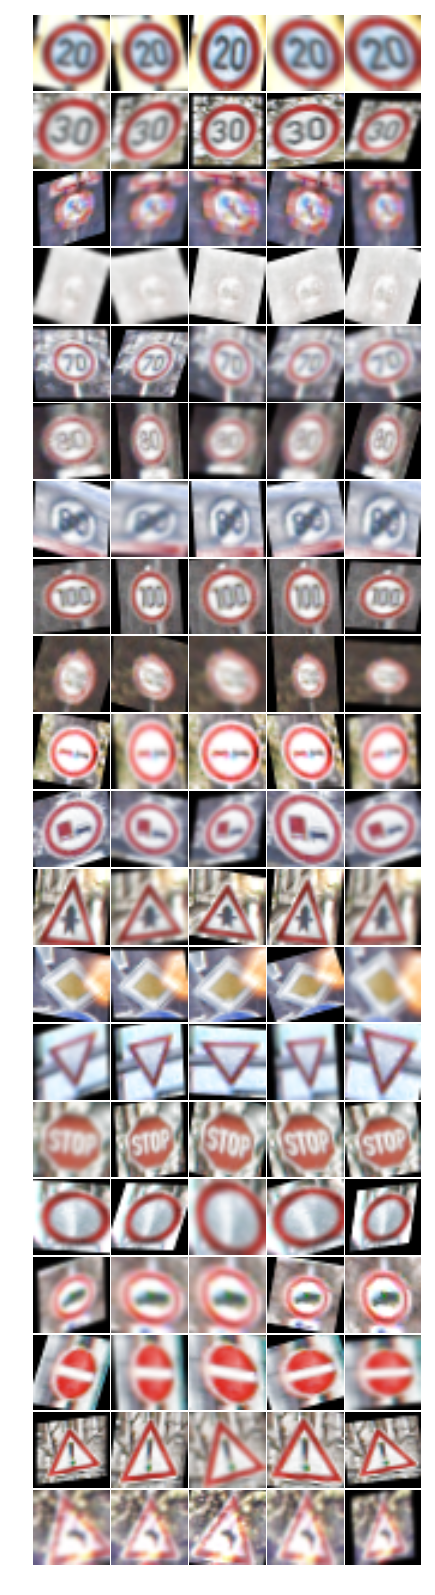

In [9]:
%matplotlib inline
classes_displayed = range(20)
n_rows = len(classes_displayed)
n_cols = 5
plt.figure(figsize=(n_cols,n_rows))
gs1 = gridspec.GridSpec(n_rows,n_cols)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
for i in range(len(classes_displayed)):
    index = np.where(y_train==classes_displayed[i])[0]
    random_selection = np.random.choice(index)
    sampled_image = brightness_normalize(X_train[random_selection])
    for j in range(n_cols):
        ax = plt.subplot(gs1[i*n_cols + j])
        plt.imshow(random_jitter(sampled_image))
        plt.axis('off')

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

def center_and_rescale(X):
    return 0.1 + X*(0.9-0.1)/255 - 0.5

X_train = np.float32([center_and_rescale(brightness_normalize(x)) for x in X_train])
X_test = np.float32([center_and_rescale(brightness_normalize(x)) for x in X_test])

def encode_label(y, n_classes):
    return y.reshape((-1,1)) == np.arange(n_classes, dtype=int).reshape((1,-1))

y_train = encode_label(y_train, n_classes)
y_test = encode_label(y_test, n_classes)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
My data preproscessing consists of 2 steps:

* Histogram equalization using CLAHE
* Min-max normalization

Histogram equalization is used to adjust unbalanced lighting across photos. CLAHE is employed for this task to even out variation in brightness not only between different photos but also among different regions within the same photo, improving the constrast of the photos, especially those taken in the dark or against backlighting. Ultimately, this steps remove noisy information about ambient lightness of the photo that is irrelevant to the classification of the signs.

Min-max normalization scales all the features to values in the same (small) range of 0 to 1, which improve numerical stability of the classification.

In [11]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split

# def shuffle(X, y):
#     perm = np.random.permutation(len(X))
#     return X[perm], y[perm]

# def train_test_split(X, y, test_size = 0.33):
#     X_shuffled, y_shuffled = shuffle(X,y)
#     m = int(len(X)*test_size)
#     return X_shuffled[m:], X_shuffled[:m], y_shuffled[m:], y_shuffled[:m]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)


In [12]:
n_sample = DATA_AUGMENTATION_MULTIPLIER

X_train_new = np.vstack(multiple_random_jitters(x, n_sample) for x in X_train)
y_train_new = np.repeat(y_train, n_sample, axis=0)
assert(len(X_train_new)==len(y_train_new))

X_train = np.vstack((X_train, X_train_new))
y_train = np.vstack((y_train, y_train_new))


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Testing data has been given, so I only set aside one-third of the training data for validation purpose. The training data were shuffled before validation data were randomly drawn from them. Randomization made sure that all classes of traffic signs would be included and their numbers would follow a realistic distribution.

Additional data were generated by transforming existing data in the training set. The following transformation were used:
* Rotation (by +10, 0 or -10 degree)
* Shear (by -7, 0, or 7 degree along horizontal and/or vertical direction)
* Scale by a factor of 0.9, 1 or 1.1
* Gausian blurs

The first 3 transformations imitate the variation of camera positions when taking the photos. The last transformation simulates variation in photo quality due to either motion, lighting or sensor.

Potentially, the following transformation can also be used:
* Motion blur along diagonal direction, to imitate a lot photos taken by moving camera
* Color jittering, to imitate uneven lighting
* Overlay small patches of opaque colors onto the photos, to imitate shadows, obstacles, reflections, etc..

The reason for data augmentation is that many photos were taken with a lot of noise, not only in color or brightness but also in camera position, motion, shadows and obstacles. These noise are not always presented in all classes in the training data, and even when presented, not in a quantity large enough to help the classifier learn. Adding these data makes sure that our classifier capable of recognizing all of these common noises in all classes, enable it to generalize better in the test set and beyond.

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

# hyperparameters
keep_prob = tf.placeholder(tf.float32)
sigma = tf.placeholder(tf.float32, shape=())

# dict to store layer specifications
relu_spec = {'type': 'relu'}
flatten_spec = {'type': 'flatten'}
dropout_spec = {'type': 'dropout'}
max_pool_spec = {
    'type': 'max_pool', 
    'ksize': [1,2,2,1], 
    'strides': [1,2,2,1], 
    'padding': 'VALID'
}

def conv_spec(W_shape):
    return {
        'type': 'conv',
        'W_shape': W_shape,
        'strides': [1,1,1,1],
        'padding': 'SAME'
    }

def linear_spec(n_output):
    return {
        'type': 'linear',
        'n_output': n_output
    }

# a sequential lenet-like network
lenet_specs = [
    'squential',
    conv_spec((3,3,3,8)),           # 32x32x8
    conv_spec((3,3,8,16)),          # 32x32x16
    relu_spec,
    max_pool_spec,                  # 16x16x16
    dropout_spec,
    conv_spec((3,3,16,32)),         # 16x16x32
    conv_spec((3,3,32,64)),         # 16x16x64
    relu_spec,
    max_pool_spec,                  # 8x8x64
    dropout_spec,
    flatten_spec,                   # 4096
    linear_spec(1024),              # 1024
    relu_spec,
    dropout_spec,
    linear_spec(n_classes)          # 43
]

# layer used in inception module/network
max_pooling_inception_spec = {
    'type': 'max_pool', 
    'ksize': [1,3,3,1], 
    'strides': [1,1,1,1], 
    'padding': 'SAME'
}

avg_pooling_inception_spec = {
    'type': 'avg_pool',
    'ksize': [1,2,2,1],
    'strides': [1,2,2,1],
    'padding': 'VALID'
}

# an individual inception module (parallel architecture)
def inception_module_spec(input_depth, output_depth):
    return [
        'parallel',
        conv_spec((1,1,input_depth,output_depth//4)),
        [
            'sequential',
            conv_spec((1,1,input_depth,output_depth//4)),
            conv_spec((3,3,output_depth//4,output_depth//2))
        ],
        [
            'sequential',
            conv_spec((1,1,input_depth,output_depth//16)),
            conv_spec((5,5,output_depth//16,output_depth//8))
        ],
        [
            'sequential',
            max_pooling_inception_spec,
            conv_spec((1,1,input_depth,output_depth//8))
        ]
    ]


inception_net = [
                                     # output     | parameters
    'sequential',
    conv_spec((3,3,3,8)),            # 32x32x16   | 3*3*3*8
    conv_spec((3,3,8,64)),           # 32x32x64   | 3*3*8*64
    relu_spec,
    max_pool_spec,                   # 16x16x64
    dropout_spec,
    
    inception_module_spec(64, 128),  # 16x16x128  | ~2*64*128 
    relu_spec,
    ['residual'] +
    inception_module_spec(128, 128), # 16x16x128  | ~2*128*128
    relu_spec,
    max_pool_spec,                   # 8x8x128
    dropout_spec,
    
    inception_module_spec(128, 256), # 8x8x256    | ~2*128*256
    relu_spec,
    ['residual'] +
    inception_module_spec(256, 256), # 8x8x256    | ~2*256*256
    relu_spec,
    max_pool_spec,                   # 4x4x256
    dropout_spec,

    avg_pooling_inception_spec,      # 2x2x256     
    flatten_spec,                    # 1024
    linear_spec(1024),               # 1024       | 1024*1024
    relu_spec,
    dropout_spec,
    linear_spec(n_classes)           # 43         | 1024*43
]

from tensorflow.contrib.layers import flatten

# generate & build a single layer
def layer_from_spec(x, spec):
    layer_type = spec['type']
    
    if layer_type == 'conv':
        conv_W = tf.Variable(tf.truncated_normal(spec['W_shape'])*sigma)
        conv_b = tf.Variable(tf.zeros(spec['W_shape'][-1]))
        return tf.nn.conv2d(x, conv_W, strides=spec['strides'], padding=spec['padding']) + conv_b
    
    elif layer_type == 'relu':
        return tf.nn.relu(x)
    
    elif layer_type == 'max_pool':
        return tf.nn.max_pool(x, ksize=spec['ksize'], strides=spec['strides'], padding=spec['padding'])

    elif layer_type == 'avg_pool':
        return tf.nn.avg_pool(x, ksize=spec['ksize'], strides=spec['strides'], padding=spec['padding'])

    elif layer_type == 'flatten':
        return flatten(x)
    
    elif layer_type == 'dropout':
        return tf.nn.dropout(x, keep_prob)
    
    elif layer_type == 'linear':
        weight_shape = (x.get_shape().as_list()[-1], spec['n_output'])
        weight = tf.Variable(tf.truncated_normal(weight_shape)*sigma)
        bias = tf.Variable(tf.zeros(weight_shape[-1]))
        return tf.matmul(x, weight) + bias
    
    return x

# generate & build a network 
# depending on the specification, will call one of the 4 other functions
# to generate & build component layers/networks
def network(x,specs):
    if isinstance(specs, (list, tuple)):
        if specs[0] == 'sequential':
            return sequential_network(x, specs[1:])
        elif specs[0] == 'parallel':
            return parallel_network(x, specs[1:])
        elif specs[0] == 'residual':
            return x + network(x, specs[1:])
        else:
            raise Exception('Invalid network type (can only be either sequential, parallel or residual), not' + str(specs))
    return layer_from_spec(x, specs)

def sequential_network(x, specs):
    layer = x
    for spec in specs:
        layer = network(layer, spec)
    return layer

def parallel_network(x, specs):
    layers = [network(x, spec) for spec in specs]
    return tf.concat(3, layers)
    
def LeNet(x):
    return network(x, lenet_specs)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I have tried to imitate 2 popular architectures: VGG and Googlenet, albeit with much more shallow design due to runtime constraint. Eventually I settled with the Googlenet-like architechture.

The final design consists of 2 convolutional layers followed by 4 inception modules and ends with 2 fully connected layers. RELU activations were used throughout (after every layers). Max-pooling and dropout were used four times after every 2 layers. All max-pooling layers use 2x2 kernel size and 2x2 strides.

The details of the design are as follows:

| # | Type      | Input     | Output   | weight    |
|--:|:----------|:----------|:---------|:----------|
| 1 | conv      | 32x32x3   | 32x32x8  | 3x3x3x8   |
| 2 | conv      | 32x32x8   | 32x32x64 | 3x3x8x64  |
|   | relu      | | | | 
|   | max_pool  | 32x32x64  | 16x16x64 |   |
|   | drop_out  | | | |
| 3 | inception | 16x16x16  | 16x16x128| \*|
|   | relu      | | | | 
| 4 | inception | 16x16x128 | 16x16x128| \*|
|   | relu      | | | | 
|   | max_pool  | 8x8x128   | 8x8x128  |   |
|   | drop_out  | | | |
| 5 | inception | 8x8x128   | 8x8x256  | \*|
|   | relu      | | | | 
| 6 | inception | 8x8x256   | 8x8x256  | \*|
|   | relu      | | | | 
|   | max_pool  | 4x4x256   | 4x4x256  |   |
|   | drop_out  | | | |
|   | avg_pool  | 4x4x256   | 2x2x256  | |
|   | flatten   | 2x2x256   | 1024     | |
| 7 | linear    | 1024      | 1024     | 1024x1024 |
|   | relu      | | | | 
|   | drop_out  | | | |
| 8 | linear    | 1024      | 43       | 1024x43   |
|   | softmax   | | | | |


In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.float32, (None, n_classes))

learning_rate = tf.placeholder(tf.float32, ())

# logits = LeNet(x)
logits = network(x, inception_net)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
opt = tf.train.AdamOptimizer(learning_rate)
train_op = opt.minimize(loss_op)


In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.

def eval_data(X_data, y_data, batch):
    steps_per_epoch = len(X_data) // batch
    num_examples = steps_per_epoch * batch
    total_acc, total_loss = 0, 0
    sess = tf.get_default_session()
    for step in range(steps_per_epoch):
        batch_x = X_data[step*batch:(step+1)*batch]
        batch_y = y_data[step*batch:(step+1)*batch]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

def eval_prediction(X_data, batch):
    steps_per_epoch = len(X_data) // batch + (len(X_data)%batch > 0)
    sess = tf.get_default_session()
    predictions = np.zeros((len(X_data), n_classes))
    for step in range(steps_per_epoch):
        batch_x = X_data[step*batch:(step+1)*batch]
        batch_y = np.zeros((len(batch_x), n_classes))
        prediction = sess.run(tf.nn.softmax(logits), feed_dict={x: batch_x,  keep_prob: 1.0})
        predictions[step*batch:(step+1)*batch] = prediction
    return predictions


In [16]:
def train(params, data, evaluate_test=False, save=False):
    print('---------------------------------------')
    print('Training with the following parameters:')
    print('---------------------------------------')
    for k,v in params.items():
        print('{:<20}: {:<30}'.format(k,v))
    print('---------------------------------------')
        
    if evaluate_test:
        X_train, y_train, X_val, y_val, X_test, y_test = data[:6]
    else:
        X_train, y_train, X_val, y_val = data[:4]
        
    batch = params['batch size']        
    steps_per_epoch = len(X_train) // batch
    num_examples = steps_per_epoch * batch
    
    sess = tf.get_default_session()

    sess.run(tf.global_variables_initializer(), feed_dict={sigma:params['sigma']})

    # Train model
    for i in range(params['epochs']):
        X_shuffle, y_shuffle = shuffle(X_train, y_train)
        for step in range(steps_per_epoch):
            sess.run(train_op, feed_dict={x: X_shuffle[step*batch:(step+1)*batch],
                                          y: y_shuffle[step*batch:(step+1)*batch], 
                                          keep_prob: params['keep prob'], 
                                          learning_rate: params['learning rate']})

        val_loss, val_acc = eval_data(X_val, y_val, 64)
        print('Epoch: {:<4} - Validation cost: {:<10.3}, accuracy: {:<5.3}'.format(i+1,val_loss, val_acc))  

    if save:
        try: saver
        except NameError: saver = tf.train.Saver()
        saver.save(sess, 'inception')
        print('Model saved')

    # Evaluate on the test data
    if evaluate_test:
        test_loss, test_acc = eval_data(X_test, y_test, 64)
        print("Test loss = {:.3f}".format(test_loss))
        print("Test accuracy = {:.3f}".format(test_acc))
        return test_loss, test_acc

    return val_loss, val_acc


In [17]:
# choosing batch size and hyperparameter

import sklearn.utils

# coarse tuning hyperparameters


batch_grid = [32, 64]
sigma_grid = [0.1, 0.01]
learning_rate_grid = [0.001, 0.0001]
keep_prob_grid = [0.5, 0.7]

param = {
    'sigma': 0.1,
    'epochs': COARSE_TUNING_EPOCHS,
    'batch size': 32,
    'learning rate': 0.001,
    'keep prob': 0.7  
}

params_grid = [{
    'sigma': s,
    'epochs': COARSE_TUNING_EPOCHS,
    'batch size': b,
    'learning rate': r,
    'keep prob': p  
} for s in sigma_grid for b in batch_grid for r in learning_rate_grid for p in keep_prob_grid]


with tf.Session() as session:
#     performances = []
#     for rate in learning_rate_grid:
#         param['learning rate'] = rate
#         param['epochs'] = int(COARSE_TUNING_EPOCHS*(np.log(max(learning_rate_grid)/rate)+1))    
#         cost, accuracy = train(param, (X_train2, y_train2, X_val, y_val))
#         performances.append(accuracy)    
#     best_learning_rate = learning_rate_grid[np.argsort(performances)[-1]]
#     param['learning rate'] = best_learning_rate
#     param['epochs'] = int(COARSE_TUNING_EPOCHS*(np.log(max(learning_rate_grid)/rate)+1))    

#     performances = []
#     for s in sigma_grid:
#         param['sigma'] = s
#         cost, accuracy = train(param, (X_train2, y_train2, X_val, y_val))
#         performances.append(accuracy)    
#     best_sigma = learning_rate_grid[np.argsort(performances)[-1]]
#     param['sigma'] = best_sigma

#     performances = []
#     for batch in batch_grid:
#         param['batch size'] = batch
#         cost, accuracy = train(param, (X_train2, y_train2, X_val, y_val))
#         performances.append(accuracy)    
#     best_batch = batch_grid[np.argsort(performances)[-1]]
#     param['batch size'] = best_batch


#     performances = []
#     for prob in keep_prob_grid:
#         param['keep prob'] = prob
#         cost, accuracy = train(param, (X_train2, y_train2, X_val, y_val))
#         performances.append(accuracy)    
#     best_prob = learning_rate_grid[np.argsort(performances)[-1]]
#     param['keep prob'] = best_prob
    print('*******************')
    print('** COARSE TUNING **')
    print('*******************')
    X_train2, y_train2 = sklearn.utils.resample(X_train, y_train, replace=False, 
                                                n_samples = int(len(X_train)*COARSE_TUNING_DOWNSAMPLING))
    coarse_performances = []
    for param in params_grid:
        param['epochs'] = int(COARSE_TUNING_EPOCHS*(np.log(max(learning_rate_grid)/param['learning rate'])+1))    
        cost, accuracy = train(param, (X_train2, y_train2, X_val, y_val))
        coarse_performances.append(accuracy)

    print('*******************')
    print('** FINE TUNING   **')
    print('*******************')
    X_train2, y_train2 = sklearn.utils.resample(X_train, y_train, replace=False, 
                                                n_samples = int(len(X_train)*FINE_TUNING_DOWNSAMPLING))

    best_params_idx = np.argsort(coarse_performances)[-1:-(FINE_TUNING_CANDIDATES+1):-1]
    best_params = [params_grid[idx] for idx in best_params_idx]
    fine_performances = []
    for param in best_params:
        param['epochs'] = FINE_TUNING_EPOCHS
        cost, accuracy = train(param, (X_train2, y_train2, X_val, y_val))
        fine_performances.append(accuracy)
        

*******************
** COARSE TUNING **
*******************
---------------------------------------
Training with the following parameters:
---------------------------------------
sigma               : 0.1                           
batch size          : 32                            
learning rate       : 0.001                         
keep prob           : 0.5                           
epochs              : 2                             
---------------------------------------
Epoch: 1    - Validation cost: 3.26      , accuracy: 0.119
Epoch: 2    - Validation cost: 2.58      , accuracy: 0.294
---------------------------------------
Training with the following parameters:
---------------------------------------
sigma               : 0.1                           
batch size          : 32                            
learning rate       : 0.001                         
keep prob           : 0.7                           
epochs              : 2                             
------------

In [18]:
with tf.Session() as session:
    print('*******************')
    print('** TRAINING   **')
    print('*******************')
    best_param = params_grid[np.argsort(coarse_performances)[-1]]
    best_param['epochs'] = 10#TRAINING_EPOCHS
    cost, accuracy = train(best_param, (X_train, y_train, X_val, y_val, X_test, y_test), True, True)


*******************
** TRAINING   **
*******************
---------------------------------------
Training with the following parameters:
---------------------------------------
sigma               : 0.1                           
batch size          : 32                            
learning rate       : 0.0001                        
keep prob           : 0.7                           
epochs              : 10                            
---------------------------------------
Epoch: 1    - Validation cost: 0.0923    , accuracy: 0.97 
Epoch: 2    - Validation cost: 0.0181    , accuracy: 0.995
Epoch: 3    - Validation cost: 0.00638   , accuracy: 0.998
Epoch: 4    - Validation cost: 0.00535   , accuracy: 0.998
Epoch: 5    - Validation cost: 0.00237   , accuracy: 0.999
Epoch: 6    - Validation cost: 0.00121   , accuracy: 1.0  
Epoch: 7    - Validation cost: 0.00218   , accuracy: 0.999
Epoch: 8    - Validation cost: 0.00133   , accuracy: 0.999
Epoch: 9    - Validation cost: 0.00198   , acc

In [52]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('inception.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    pred = eval_prediction(X_test, 64)

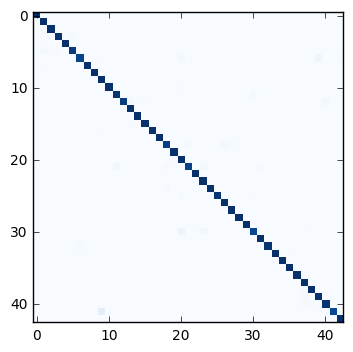

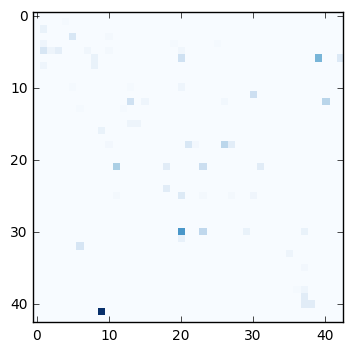

In [67]:
%matplotlib inline

true_label = np.argmax(y_test,axis=1)
pred_label = np.argmax(pred,axis=1)
from sklearn.metrics import confusion_matrix
cm_abs = confusion_matrix(true_label, pred_label)
cm_rel = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_rel, interpolation='nearest',cmap=plt.cm.Blues)
cm_rel_offdiag = cm_rel
for j in range(len(cm)): cm_rel_offdiag[j,j] = 0
plt.figure()
plt.imshow(cm_rel_offdiag, interpolation='nearest',cmap=plt.cm.Blues)


In [75]:
cm2 = cm_rel
for j in range(len(cm)): cm2[j,j] = 0
print('{:>6} {:>6} {:>11} {:>6}'.format('truth', 'pred', 'inaccuracy', '#'))
print('-------------------------------')
print('\n'.join(list(' {:>6} {:>6} {:>10.3f}% {:>6}'.format(*a) for a in  sorted((i,j, cm2[i,j]*100,cm_abs[i,j]) for i in range(n_classes) for j in range(n_classes) if cm2[i,j] > 0)[::-1])))

 truth   pred  inaccuracy      #
-------------------------------
     41      9     10.000%      6
     40     38      1.111%      1
     40     37      1.111%      1
     39     37      1.111%      1
     38     37      0.435%      3
     38     36      0.145%      1
     35     37      0.256%      1
     33     35      0.476%      1
     32      6      1.667%      1
     31     20      0.741%      2
     30     37      0.667%      1
     30     29      0.667%      1
     30     23      2.667%      4
     30     20      6.000%      9
     25     30      0.417%      2
     25     27      0.208%      1
     25     23      0.208%      1
     25     20      1.250%      6
     25     11      0.208%      1
     24     18      1.111%      1
     21     31      1.111%      1
     21     23      2.222%      2
     21     18      1.111%      1
     21     11      3.333%      3
     18     27      1.026%      4
     18     26      2.821%     11
     18     22      0.256%      1
     18     21   

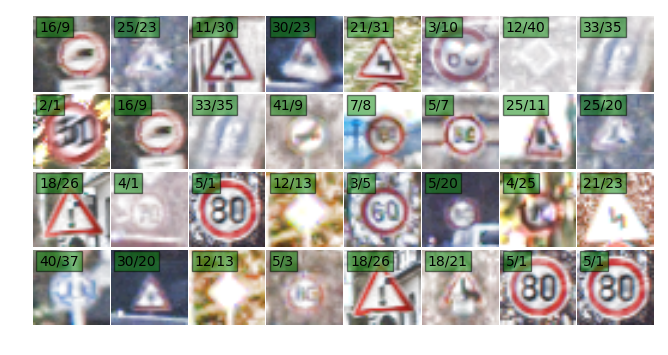

In [21]:
n_rows = 4
n_cols = 8
n_resamples = n_rows*n_cols

incorrect_label_idx, = np.where(true_label != pred_label)
resampled_idx = resample(incorrect_label_idx, n_samples=n_resamples)

X_test_original = test['features']

resampled_images = X_test_original[resampled_idx]
resampled_truths = true_label[resampled_idx]
resampled_labels = pred_label[resampled_idx]

plt.figure(figsize=(n_cols,n_rows))
gs1 = gridspec.GridSpec(n_rows,n_cols)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
for i in range(n_rows):
    for j in range(n_cols):
        ax = plt.subplot(gs1[i*n_cols + j])
        plt.imshow(brightness_normalize(resampled_images[i*n_cols + j]))
        ax.text(2,6,str(resampled_truths[i*n_cols+j]) + '/' + str(resampled_labels[i*n_cols+j]), bbox={'facecolor':'green', 'alpha':0.5, 'pad':2})
        plt.axis('off')



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
AdamOptimizer is used to train the model. Hyperparameters, including batch size, are fine tuned by grid-search over validation performance. I used 2 stage grid-search
* First stage: coarse tuning b y training with 2% of training set over a small number of epochs; the purpose is the eliminate situations where the search gets stuck at local minimum from beginning
* Second stage: fine tuning by training with 10% of the training set over 10 epochs; the set of hyperparameters that gives the best accuracy will be used for actual training

Training is run for 10 epochs due to time constraint. The final model achieved 98.5% accuracy on the testing set.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

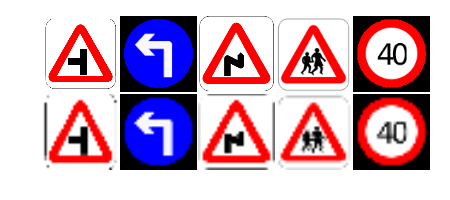

In [22]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import glob

%matplotlib inline

n_cols = 5
n_rows = 2

filenames = np.random.choice(glob.glob('./singapore-signs/*.png'),n_cols)
    
plt.figure(figsize=(n_cols,n_rows))
gs1 = gridspec.GridSpec(n_rows,n_cols)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
imgs = []
resized_imgs = []

for j in range(n_cols):
    imgs.append(cv2.cvtColor(cv2.imread(filenames[j]), cv2.COLOR_BGR2RGB))
    resized_imgs.append(cv2.resize(imgs[-1], (32,32), interpolation = cv2.INTER_CUBIC))
    ax = plt.subplot(gs1[j])
    plt.imshow(imgs[-1])
    plt.axis('off')
    ax = plt.subplot(gs1[n_cols+j])
    plt.imshow(resized_imgs[-1])
    plt.axis('off')
    

In [23]:
X_captured = np.array(resized_imgs)
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('inception.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    pred = eval_prediction(X_captured, 64)

In [24]:
print(pred)
pred_labels = np.argmax(pred, axis=1)
[signnames[j] for j in pred_labels]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]]


['General caution/#18',
 'Go straight or right/#36',
 'Bumpy road/#22',
 'Pedestrians/#27',
 'No vechiles/#15']

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [25]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.